In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/bi_vinfast"


Mounted at /content/drive


In [22]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (11,5)
plt.rcParams["axes.grid"] = True

BASE = "/content/drive/MyDrive/bi_vinfast"
DATA = os.path.join(BASE)
EXPORTS = os.path.join(BASE, "exports")
FIGS = os.path.join(EXPORTS, "figures")
os.makedirs(FIGS, exist_ok=True)

FN_FINANCE = os.path.join(DATA, "vinfast_market_quarterly.csv")
FN_STOCK   = os.path.join(DATA, "VFS.csv")
FN_MARKET  = os.path.join(DATA, "competitor_market_share.csv")


In [23]:
df_fin = pd.read_csv(FN_FINANCE)
df_stock = pd.read_csv(FN_STOCK)
df_market = pd.read_csv(FN_MARKET)

print("=== SHAPE ===")
print("Finance:", df_fin.shape)
print("Stock  :", df_stock.shape)
print("Market :", df_market.shape)

print("\n=== INFO (Finance) ===")
print(df_fin.info())
print("\n=== INFO (Stock) ===")
print(df_stock.info())
print("\n=== INFO (Market) ===")
print(df_market.info())

print("\n=== SAMPLE HEADS ===")
display(df_fin.head(3))
display(df_stock.head(3))
display(df_market.head(3))


=== SHAPE ===
Finance: (12, 6)
Stock  : (779, 7)
Market : (720, 8)

=== INFO (Finance) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   period              12 non-null     object 
 1   revenue             12 non-null     int64  
 2   operating_expenses  12 non-null     int64  
 3   net_income          12 non-null     int64  
 4   growth_rate         8 non-null      float64
 5   operating_margin    12 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 708.0+ bytes
None

=== INFO (Stock) ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       779 non-null    object 
 1   Open       779 non-null    float64
 2   High       779 non-null    float64
 3   Low        7

,period,revenue,operating_expenses,net_income,growth_rate,operating_margin
0,2023Q1,5000,16000,-11000,NaN,-220.0
1,2023Q2,6500,17500,-11500,NaN,-169.2
2,2023Q3,8500,19000,-12000,NaN,-123.5


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-03,9.79,9.79,9.79,9.79,9.79,1600
1,2022-10-04,9.79,9.79,9.79,9.79,9.79,0
2,2022-10-05,9.79,9.79,9.79,9.79,9.79,0


,period,brand,model,market_share_pct,units_sold,avg_price_vnd,region,growth_rate
0,2024Q1,VinFast,VF5,26.22,3587,406145122,Vietnam_North,NaN
1,2024Q1,Toyota,Corolla Cross,9.75,1334,988909353,Vietnam_North,NaN
2,2024Q1,Hyundai,Creta,14.33,1960,546047356,Vietnam_North,NaN


In [24]:
def normalize_period(s):
    s = str(s).strip()
    if 'Q' in s:
        if '/' in s:
            parts = s.split('/')
            q = int(parts[0].replace('Q',''))
            y = int(parts[1])
        else:
            parts = s.split('Q')
            y = int(parts[0])
            q = int(parts[1])

        month = {1:3, 2:6, 3:9, 4:12}[q]
        return pd.Timestamp(year=y, month=month, day=1) + pd.offsets.MonthEnd(0)

    return pd.to_datetime(s, errors='coerce')

df_fin['period_dt'] = df_fin['period'].apply(normalize_period)
df_fin = df_fin.sort_values('period_dt').reset_index(drop=True)

# Các cột nên có: revenue, operating_expenses, net_income
# Nếu thiếu growth_rate/operating_margin thì tạo
if 'growth_rate' not in df_fin.columns:
    df_fin['growth_rate'] = df_fin['revenue'].pct_change()
if 'operating_margin' not in df_fin.columns:
    # Operating Margin = (Revenue - Operating Expenses) / Revenue
    df_fin['operating_margin'] = (df_fin['revenue'] - df_fin['operating_expenses'])/df_fin['revenue']

# Stock: Date
df_stock['Date'] = pd.to_datetime(df_stock['Date'], errors='coerce')
df_stock = df_stock.sort_values('Date').reset_index(drop=True)

# Tạo daily return, volatility, drawdown
df_stock['Return'] = df_stock['Close'].pct_change()
df_stock['Volatility20'] = df_stock['Return'].rolling(20).std() * np.sqrt(252)
df_stock['CumMax'] = df_stock['Close'].cummax()
df_stock['Drawdown'] = df_stock['Close']/df_stock['CumMax'] - 1

# Market share: period chuẩn hoá
df_market['period_dt'] = df_market['period'].apply(normalize_period)

In [25]:
def missing_report(df, name):
    miss = df.isna().sum()
    print(f"\n=== Missing values ({name}) ===")
    print(miss[miss > 0].sort_values(ascending=False))

missing_report(df_fin, "Finance")
missing_report(df_stock, "Stock")
missing_report(df_market, "Market")

print("\n=== Describe (Finance) ===")
display(df_fin[['revenue','operating_expenses','net_income','growth_rate','operating_margin']].describe().T)

print("\n=== Describe (Stock - numeric) ===")
num_cols = df_stock.select_dtypes(include=[np.number]).columns
display(df_stock[num_cols].describe().T)

print("\n=== Market share – brands, regions, periods ===")
print("Brands:", sorted(df_market['brand'].dropna().unique()))
print("Regions:", sorted(df_market['region'].dropna().unique()))
print("Periods:", df_market['period'].dropna().unique())



=== Missing values (Finance) ===
growth_rate    4
dtype: int64

=== Missing values (Stock) ===
Volatility20    20
Return           1
dtype: int64

=== Missing values (Market) ===
growth_rate    361
dtype: int64

=== Describe (Finance) ===


,count,mean,std,min,25%,50%,75%,max
revenue,12.0,12983.333333,5475.039781,5000.0,9625.000,12400.0,16125.000,25000.0
operating_expenses,12.0,22708.333333,3701.709269,16000.0,20500.000,24000.0,24625.000,28000.0
net_income,12.0,-11291.666667,3784.047456,-18500.0,-13350.000,-11750.0,-8875.000,-4000.0
growth_rate,8.0,60.025000,31.325195,28.0,40.825,48.1,71.825,120.0
operating_margin,12.0,-95.458333,57.038256,-220.0,-113.375,-95.6,-58.275,-12.0



=== Describe (Stock - numeric) ===


,count,mean,std,min,25%,50%,75%,max
Open,779.0,6.893385e+00,6.130871e+00,2.470000,3.640000,4.780000,1.000300e+01,8.400000e+01
High,779.0,7.182085e+00,7.101378e+00,2.507000,3.730000,4.910000,1.001250e+01,9.300000e+01
Low,779.0,6.635919e+00,5.284043e+00,2.255000,3.557500,4.540000,1.000000e+01,7.592000e+01
Close,779.0,6.879404e+00,5.986909e+00,2.420000,3.620000,4.730000,1.000750e+01,8.235000e+01
Adj Close,779.0,6.879404e+00,5.986909e+00,2.420000,3.620000,4.730000,1.000750e+01,8.235000e+01
Volume,779.0,1.356701e+06,2.176130e+06,0.000000,188150.000000,613800.000000,1.513850e+06,1.940450e+07
Return,778.0,2.577380e-03,1.169204e-01,-0.438373,-0.015279,0.000000,8.702073e-03,2.546412e+00
Volatility20,759.0,8.285824e-01,1.678318e+00,0.007358,0.231763,0.467947,7.902777e-01,1.078756e+01
CumMax,779.0,6.182703e+01,3.231897e+01,9.790000,10.360000,82.349998,8.235000e+01,8.235000e+01
Drawdown,779.0,-6.706266e-01,4.233324e-01,-0.970613,-0.956041,-0.942562,-6.789521e-03,0.000000e+00



=== Market share – brands, regions, periods ===
Brands: ['BYD', 'Ford', 'Geely', 'Great Wall', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mercedes', 'Mitsubishi', 'Nissan', 'Tesla', 'Toyota', 'VinFast', 'Wuling']
Regions: ['Indonesia', 'Malaysia', 'Thailand', 'Vietnam_Central', 'Vietnam_North', 'Vietnam_South']
Periods: ['2024Q1' '2024Q2' '2024Q3' '2024Q4' '2025Q1' '2025Q2' '2025Q3' '2025Q4']


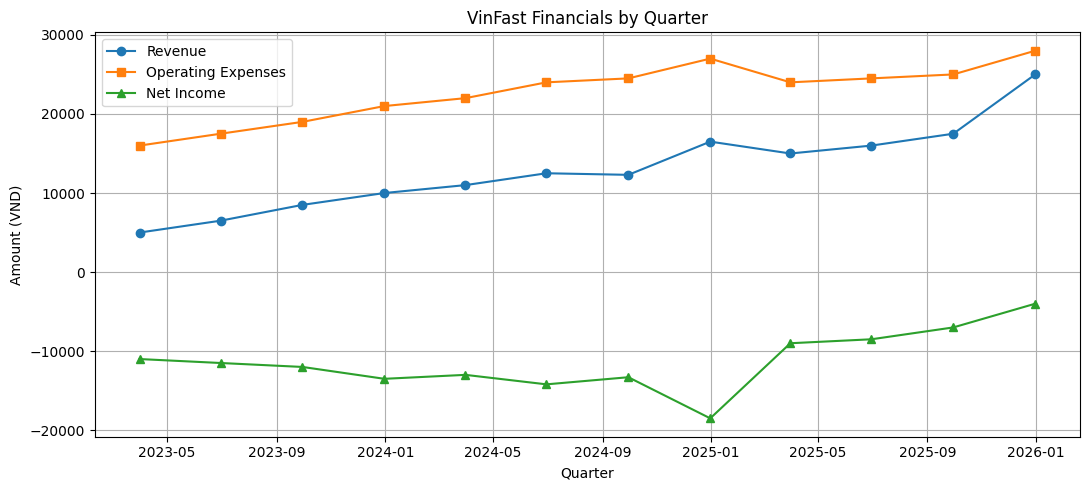

In [26]:
fig, ax = plt.subplots()
ax.plot(df_fin['period_dt'], df_fin['revenue'], marker='o', label='Revenue')
ax.plot(df_fin['period_dt'], df_fin['operating_expenses'], marker='s', label='Operating Expenses')
ax.plot(df_fin['period_dt'], df_fin['net_income'], marker='^', label='Net Income')
ax.set_title("VinFast Financials by Quarter")
ax.set_xlabel("Quarter"); ax.set_ylabel("Amount (VND)")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "financials_by_quarter.png"), dpi=200)
plt.show()


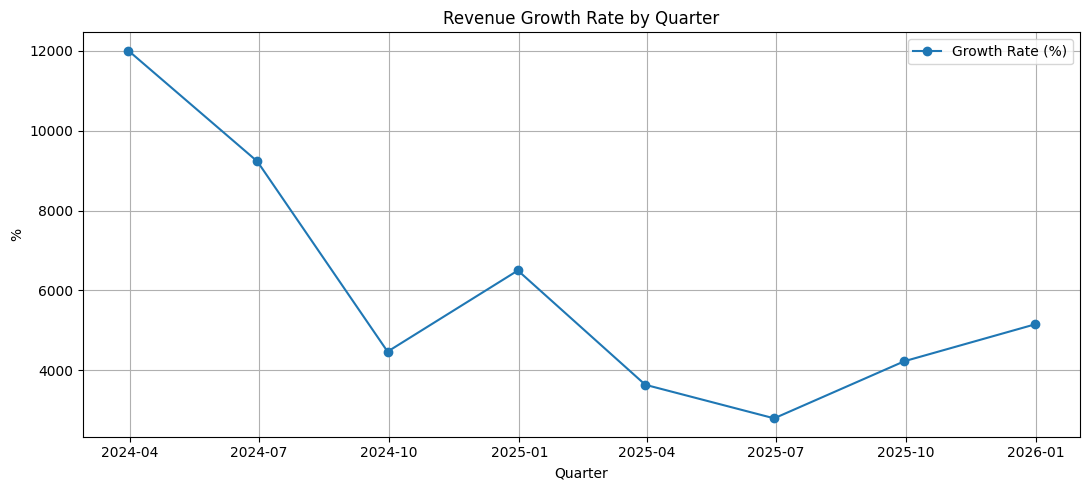

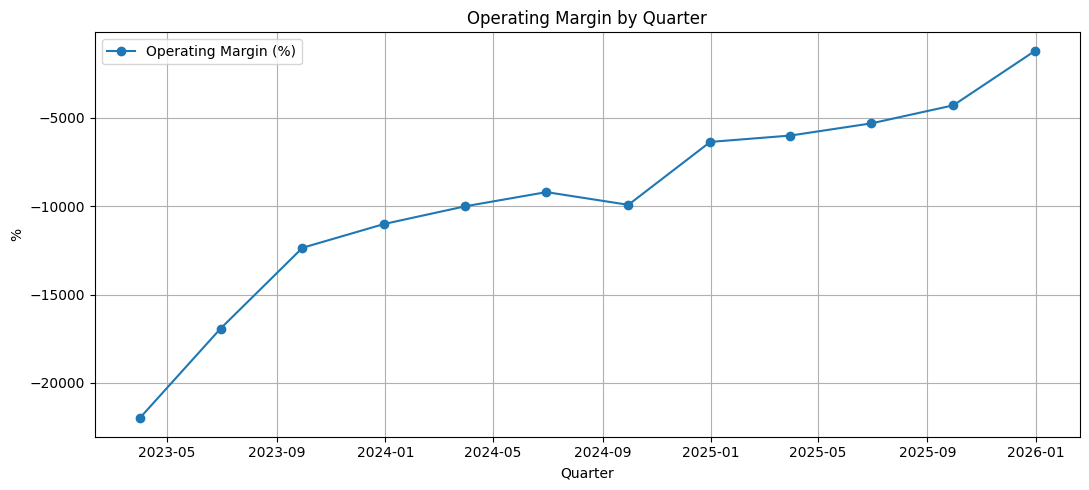

In [27]:
fig, ax = plt.subplots()
ax.plot(df_fin['period_dt'], df_fin['growth_rate']*100, marker='o', label='Growth Rate (%)')
ax.set_title("Revenue Growth Rate by Quarter")
ax.set_xlabel("Quarter"); ax.set_ylabel("%")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "growth_rate_by_quarter.png"), dpi=200)
plt.show()

fig, ax = plt.subplots()
ax.plot(df_fin['period_dt'], df_fin['operating_margin']*100, marker='o', label='Operating Margin (%)')
ax.set_title("Operating Margin by Quarter")
ax.set_xlabel("Quarter"); ax.set_ylabel("%")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "operating_margin_by_quarter.png"), dpi=200)
plt.show()


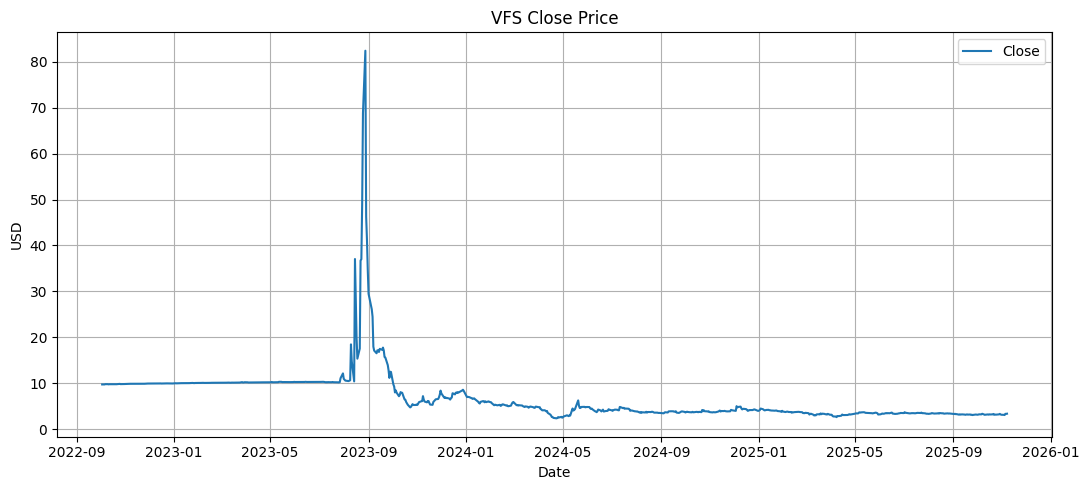

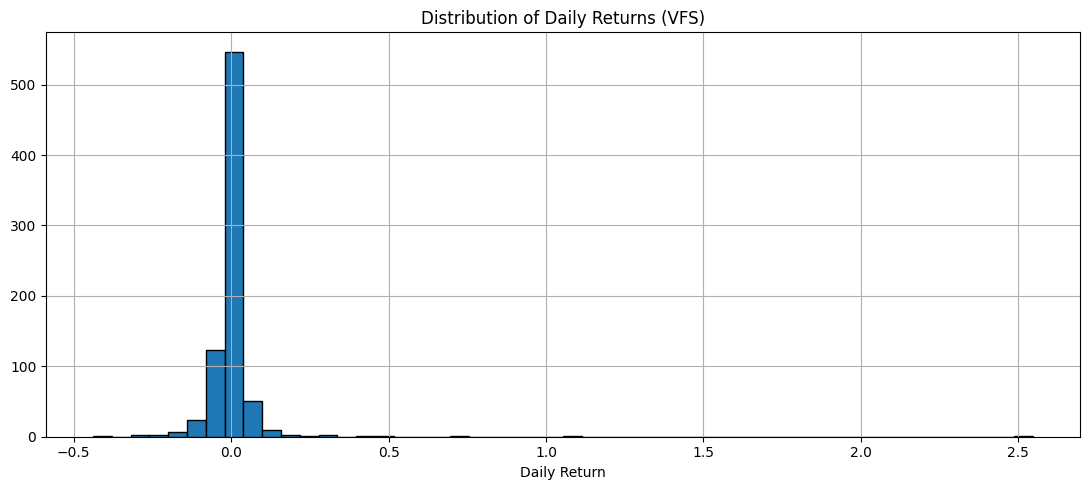

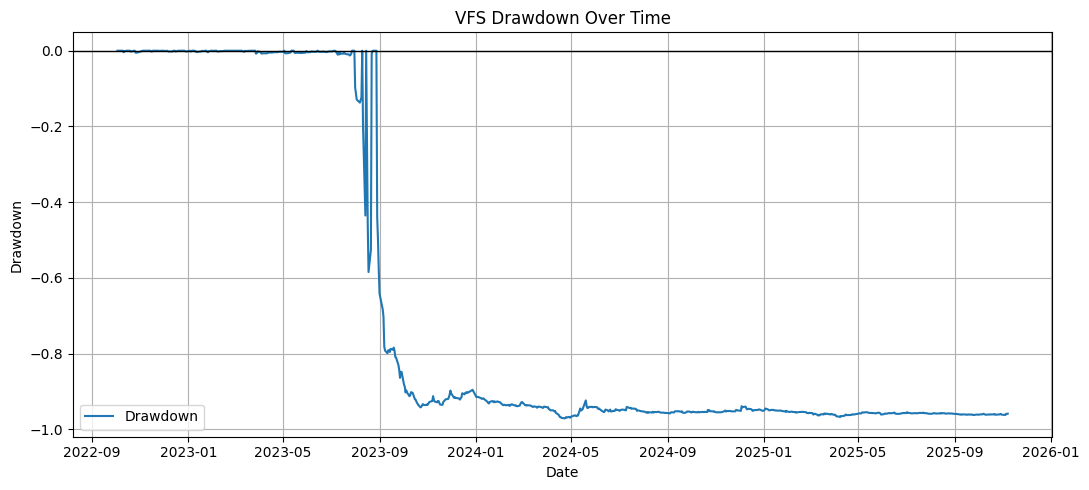

In [28]:
# Close price
fig, ax = plt.subplots()
ax.plot(df_stock['Date'], df_stock['Close'], label='Close')
ax.set_title("VFS Close Price")
ax.set_xlabel("Date"); ax.set_ylabel("USD")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "stock_close.png"), dpi=200)
plt.show()

# Daily returns distribution
fig, ax = plt.subplots()
ax.hist(df_stock['Return'].dropna(), bins=50, edgecolor='black')
ax.set_title("Distribution of Daily Returns (VFS)")
ax.set_xlabel("Daily Return")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "stock_returns_hist.png"), dpi=200)
plt.show()

# Drawdown
fig, ax = plt.subplots()
ax.plot(df_stock['Date'], df_stock['Drawdown'], label='Drawdown')
ax.axhline(0, color='k', linewidth=1)
ax.set_title("VFS Drawdown Over Time")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "stock_drawdown.png"), dpi=200)
plt.show()


brand,BYD,Ford,Geely,Great Wall,Honda,Hyundai,Kia,Mazda,Mercedes,Mitsubishi,Nissan,Tesla,Toyota,VinFast,Wuling
period_dt,,,,,,,,,,,,,,,
2024-12-31,9.136667,3.676667,5.021667,2.071667,4.228333,13.248333,6.178333,3.060000,2.901667,1.838333,3.390000,6.970000,18.566667,13.975000,5.740000
2025-03-31,10.196667,5.180000,5.295000,2.695000,2.590000,13.706667,3.655000,4.530000,1.873333,2.451667,7.391667,9.538333,14.151667,10.898333,5.853333
2025-06-30,7.541667,9.785000,6.250000,5.798333,3.856667,8.661667,1.838333,4.305000,2.183333,2.320000,1.725000,9.845000,16.128333,13.471667,6.291667
2025-09-30,4.503333,4.185000,3.130000,5.468333,5.933333,16.811667,4.340000,3.428333,2.888333,5.915000,3.563333,6.448333,17.011667,13.303333,3.066667
2025-12-31,7.708333,3.458333,2.153333,2.913333,5.311667,17.215000,2.521667,3.730000,5.676667,2.348333,3.908333,6.940000,12.285000,17.520000,6.313333


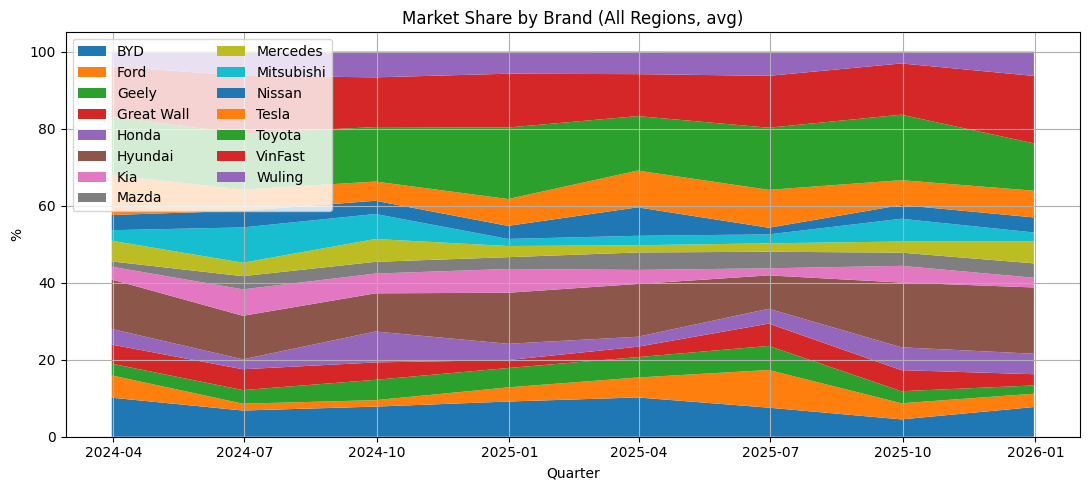

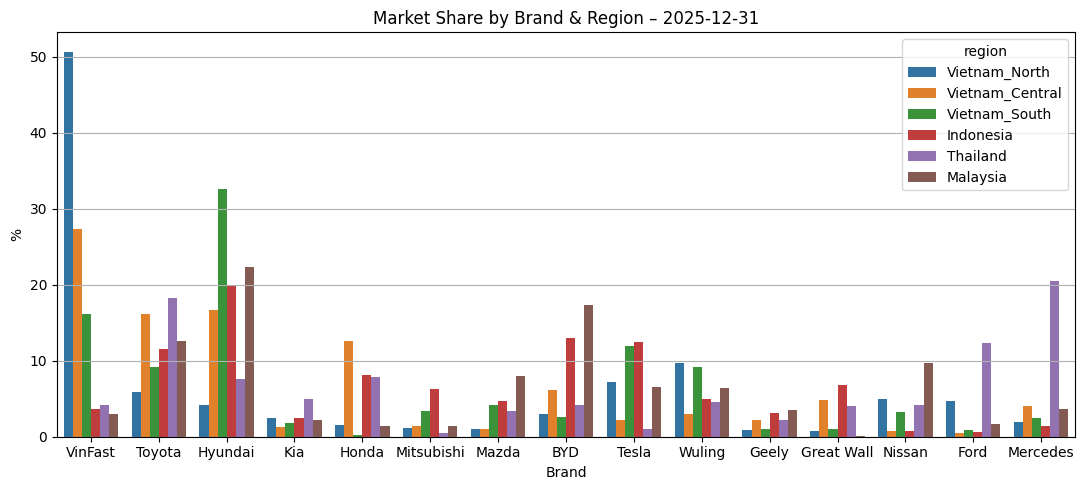

In [29]:
# Pivot: market share by brand per period (all regions)
pivot_brand = df_market.pivot_table(index='period_dt', columns='brand', values='market_share_pct', aggfunc='mean')
display(pivot_brand.tail())

# Stacked area (tổng hợp các brand)
pivot_brand.sort_index(inplace=True)
fig, ax = plt.subplots()
ax.stackplot(pivot_brand.index, pivot_brand.fillna(0).T, labels=pivot_brand.columns)
ax.set_title("Market Share by Brand (All Regions, avg)")
ax.set_ylabel("%"); ax.set_xlabel("Quarter")
ax.legend(loc='upper left', ncols=2)
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "market_share_stack_all_regions.png"), dpi=200)
plt.show()

# Barplot theo Region tại kỳ gần nhất
latest_period = df_market['period_dt'].max()
df_latest = df_market[df_market['period_dt']==latest_period]
fig, ax = plt.subplots()
sns.barplot(data=df_latest, x='brand', y='market_share_pct', hue='region', ax=ax)
ax.set_title(f"Market Share by Brand & Region – {latest_period.date()}")
ax.set_ylabel("%"); ax.set_xlabel("Brand")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "market_share_bar_latest.png"), dpi=200)
plt.show()


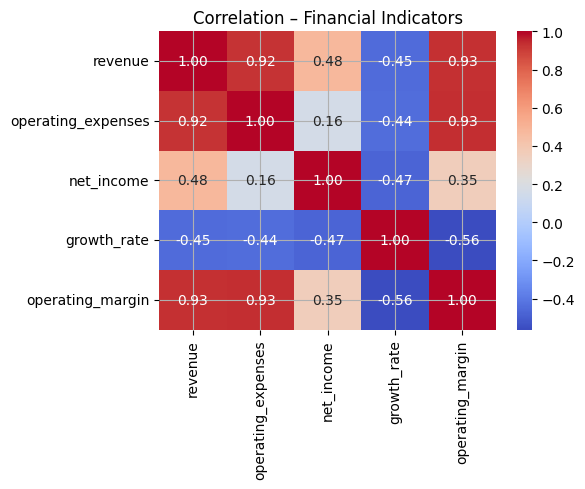

In [30]:
finance_cols = ['revenue','operating_expenses','net_income']
if 'growth_rate' in df_fin.columns: finance_cols.append('growth_rate')
if 'operating_margin' in df_fin.columns: finance_cols.append('operating_margin')

corr = df_fin[finance_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation – Financial Indicators")
plt.tight_layout()
plt.savefig(os.path.join(FIGS, "financial_correlation.png"), dpi=200)
plt.show()


In [31]:
# Best/Worst quarter theo lợi nhuận
best_q = df_fin.loc[df_fin['net_income'].idxmax()]
worst_q = df_fin.loc[df_fin['net_income'].idxmin()]

# CAGR Revenue (nếu có >=2 điểm)
rev = df_fin[['period_dt','revenue']].dropna()
if len(rev) >= 2:
    years = (rev['period_dt'].max() - rev['period_dt'].min()).days/365.25
    cagr = (rev['revenue'].iloc[-1]/rev['revenue'].iloc[0])**(1/years) - 1 if years>0 else np.nan
else:
    cagr = np.nan

avg_margin = df_fin['operating_margin'].mean()
loss_quarters = (df_fin['net_income'] < 0).sum()

# Stock KPIs
vol_20 = df_stock['Volatility20'].iloc[-1] if df_stock['Volatility20'].notna().any() else np.nan
max_dd = df_stock['Drawdown'].min()

# Market share avg by brand (overall)
ms_brand = df_market.groupby('brand')['market_share_pct'].mean().sort_values(ascending=False)

summary = {
    "Best quarter (by Net Income)": str(best_q['period']),
    "Worst quarter (by Net Income)": str(worst_q['period']),
    "Revenue CAGR": f"{cagr*100:.2f}%" if pd.notna(cagr) else "N/A",
    "Avg Operating Margin": f"{avg_margin*100:.2f}%" if pd.notna(avg_margin) else "N/A",
    "Number of Loss Quarters": int(loss_quarters),
    "Stock Volatility (20d, annualized)": f"{vol_20*100:.2f}%" if pd.notna(vol_20) else "N/A",
    "Max Drawdown (stock)": f"{max_dd*100:.2f}%" if pd.notna(max_dd) else "N/A",
}

print("=== KPI SUMMARY ===")
for k,v in summary.items():
    print(f"{k}: {v}")

print("\n=== Average Market Share by Brand (%) ===")
display(ms_brand.round(2))

# Lưu summary ra CSV để trích vào báo cáo
pd.Series(summary).to_csv(os.path.join(EXPORTS, "kpi_summary.csv"))
ms_brand.round(2).to_csv(os.path.join(EXPORTS, "market_share_brand_avg.csv"))


=== KPI SUMMARY ===
Best quarter (by Net Income): 2025Q4
Worst quarter (by Net Income): 2024Q4
Revenue CAGR: 79.38%
Avg Operating Margin: -9545.83%
Number of Loss Quarters: 12
Stock Volatility (20d, annualized): 44.08%
Max Drawdown (stock): -97.06%

=== Average Market Share by Brand (%) ===


,market_share_pct
brand,
Toyota,15.24
VinFast,13.77
Hyundai,12.96
BYD,7.98
Tesla,7.58
Wuling,5.51
Honda,4.57
Ford,4.44
Kia,4.23


In [32]:
# Chuẩn bị biến an toàn
def fmt_pct(x):
    return f"{x*100:.2f}%" if pd.notna(x) else "N/A"

rev_first = rev['revenue'].iloc[0] if len(rev)>=1 else np.nan
rev_last  = rev['revenue'].iloc[-1] if len(rev)>=1 else np.nan

top_brand = ms_brand.index[0] if len(ms_brand)>0 else "N/A"
top_brand_share = ms_brand.iloc[0] if len(ms_brand)>0 else np.nan

eda_paragraph = f"""
Over the observed period, VinFast’s quarterly revenue moved from {rev_first:,.0f} to {rev_last:,.0f}
VND, corresponding to a CAGR of {summary['Revenue CAGR']}. Operating expenses remained elevated,
resulting in an average operating margin of {summary['Avg Operating Margin']}. Net income stayed
negative in {summary['Number of Loss Quarters']} quarter(s). The best-performing quarter by net income was
{summary['Best quarter (by Net Income)']}, while the weakest quarter was {summary['Worst quarter (by Net Income)']}.

On the equity side, VFS exhibited an annualized 20-day volatility of {summary['Stock Volatility (20d, annualized)']},
with a maximum drawdown of {summary['Max Drawdown (stock)']}. In competitive analysis, {top_brand} held the highest
average market share at {top_brand_share:.2f}% across regions and periods in our dataset.
""".strip()

print(eda_paragraph)

with open(os.path.join(EXPORTS, "eda_paragraph.txt"), "w", encoding="utf-8") as f:
    f.write(eda_paragraph)
print("\nSaved:", os.path.join(EXPORTS, "eda_paragraph.txt"))


Over the observed period, VinFast’s quarterly revenue moved from 5,000 to 25,000 
VND, corresponding to a CAGR of 79.38%. Operating expenses remained elevated, 
resulting in an average operating margin of -9545.83%. Net income stayed 
negative in 12 quarter(s). The best-performing quarter by net income was 
2025Q4, while the weakest quarter was 2024Q4.

On the equity side, VFS exhibited an annualized 20-day volatility of 44.08%, 
with a maximum drawdown of -97.06%. In competitive analysis, Toyota held the highest 
average market share at 15.24% across regions and periods in our dataset.

Saved: /content/drive/MyDrive/bi_vinfast/exports/eda_paragraph.txt
